# Reaction Wheel Failure

начато Павлом Белоклоковым, Б03-901

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

In [285]:
# Вспомогательные функции

def normalize(obj):

    return obj / np.linalg.norm(obj)


def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat2rpy_deg(q0, q1, q2, q3):
    
    norm_q = np.linalg.norm([q0, q1, q2, q3]) 
#     norm_q = np.linalg.norm([q0, q1, q2, q3], axis=0) 
    q0, q1, q2, q3 = q0/norm_q, q1/norm_q, q2/norm_q, q3/norm_q 
    

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))*180/np.pi
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))*180/np.pi
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))*180/np.pi

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

In [308]:
MU_0 = 1.257e-6                                # [N / A^2] vacuum permeability
MU_e = 7.94e+22                                # [A * m^2] magnetic dipole moment of the Earth

R_e = 6371e+3                                  # [m] radius of the Earth
altitude = 450e+3                              # [m] altitude of the orbit
# altitude = 409e+3                              # [m] altitude of the orbit
incl = 87*np.pi / 180                       # [rad] inclination of the orbit
# incl = 51.63*np.pi / 180                       # [rad] inclination of the orbit

R_orb = R_e + altitude                         # [m] radius of the orbit
B_0 = MU_e * MU_0 / (4 * np.pi * R_orb**3.)    # [T] magnitude of the magnetic field  on the orbit

def B_fun(u, i, B_0):

    """
    Magnetic field on the orbit
    :param u: latitude in rad
    :param i: inclination in rad
    :returns: 3-axis magnetic field
    """

    return np.array([np.cos(u)*np.sin(i), np.cos(i), -2.*np.sin(u)*np.sin(i)]) * B_0

## Уравнения движения и управления

Используются две системы отсчета:
1) Орбитальная СО $F^o$ с началом в центре массы спутника. Ось $\mathbf{z}$ направлена по вектору к центру спутника от центра Земли, ось $\mathbf{y}$ лежит по векторному произведению вектора центра спутника и вектора скорости, ось $\mathbf{x}$ дополняет до правой тройки.

2) Собственная СО $F^b$ с началом в центре массы спутника. Оси лежат по трем главным осям инерции спутника.

Уравнения движения записываются в виде:

$$\left\{ 
\begin{array}\\
\dot{q}^{ib} = \frac{1}{2} q^{ib} \circ \boldsymbol{\omega}^b \\
\mathbf{J}^b\cdot\dot{\boldsymbol{\omega}}^b= -\boldsymbol{\omega}^b \times (\mathbf{J}^b \cdot \boldsymbol{\omega}^b + \mathbf{h}_w) + \mathbf{M}_{ctrl}^b \\
\dot{\mathbf{h}}_w = -\mathbf{M}_{rw}^b
\end{array}
\right. $$

Закон управления согласно фукнции Ляпунова:

$$
\mathbf{M}_{ctrl}^b = \boldsymbol{\omega}^b \times (\mathbf{J}^b \cdot \boldsymbol{\omega}^b + \mathbf{h}_w) - \mathbb{K}_d\cdot \boldsymbol{\omega}_e - q_{e,0} \cdot \mathbb{K}_p \cdot \mathbf{q}_e
$$

где $q_e$ и $\boldsymbol{\omega}_e$ - кватернион ошибки и ошибка по угловой скорости:
$$\left\{ 
\begin{array}\\
q_e = \tilde{q}_d \circ q^{ib} \\
\boldsymbol{\omega}_e = \boldsymbol{\omega}^b - \tilde{q}_e \circ \boldsymbol{\omega}_d \circ q_e
\end{array}
\right. $$

В случае поломки одного из маховиков (RW), управление осуществляется оставшимися двумя и модулем, создающим магнитный момент (ничего лучше пока не смог придумать и не нашел) (MTQ).  
В такой постановке управляемый крутящий момент записывается:

$$
\mathbf{M}_{ctrl}^b = - \dot{\mathbf{h}}_w + \mathbf{m}^b \times \mathbf{B}^b
$$

где $- \dot{\mathbf{h}}_w = \mathbf{u}$ - крутящий момент модулей RW.

Пусть сломан маховик под номером $v \in{\{0, 1, 2\}}$. $S = \{0, 1, 2\} \backslash \{v\}$. Решение записывается в виде:

$$
\begin{align}
&k = \arg \min_{i \in S}{|B_i|}, \\
&\lambda_i = Sat(\frac{M_v}{B_i}, m_{max}), \\
&u_i = (1 - \delta_{iv})M_i + |\varepsilon_{ivk}|B_v \lambda_i, \\
&m_j = \delta_{jk} \sum_i{\varepsilon_{vji} \lambda_i}
\end{align}
$$

Конечная цель - совместить систему $F^b$ с системой $F^o$.  
$q_d = [1, 0, 0, 0]^T$  
$\omega_d = [0, \omega_0, 0]^T$  
где $\omega_0$ - скорость движения спутника по орбите.

Функция *B_fun* дает магнитное поле в системе $F^o$. В систему $F^b$ перевожу так же, как $\boldsymbol{\omega}_d$ в ошибке угловой скорости:
$$
\mathbf{B}^b = \tilde{q}_e \circ \boldsymbol{B}^o \circ q_e
$$

Орбита круговая, аргумент широты $u_{angle} = \omega_0 \cdot t$

Касательно кода:  
Так как по функции *ctrl_torque* в дальнейшем строится график воздействия, я вынес туда расчет всех крутящих моментов.  
В ней сперва рассчитывается $\mathbf{M}_{ctrl}$, затем по формулам выше высчитываются управляемые воздействия $u, m$, сравниваются с максимально возможными, в конце пересчитывается $\mathbf{M}_{ctrl}$ и возвращаются $\mathbf{u}, \mathbf{m}, \mathbf{M}_{ctrl}$ для возможности построения их графиков при необходимости.  
Переменная $\mathbf{v}$ - сломанный RW, $\mathbf{k}$ - ось минимального магнитного поля без индекса v (формула выше), $\mathbf{l}$ - оставшийся индекс, ввел для удобства.  
Нетрудно заметить, что переменная $\lambda_i$ будет расчитываться только для индекса l.

In [287]:
def levi_civita(i, j, k):
    return (i-j)*(j-k)*(k-i)/2

def ctrl_torque(t, quat, omega, h, ctrl, J):
    
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    dw = omega - rotate_vec_with_quat(dq, ctrl.omega_req)

    M_ctrl = np.zeros(3)
    M_ctrl = cross_product(omega, J @ omega + h) - ctrl.K_d @ dw - dq[0] * ctrl.K_p @ dq[1:]
    
    u_angle = ctrl.w0 * t
    B_o = B_fun(u_angle, incl, B_0)
    B_b = rotate_vec_with_quat(dq, B_o)

    v = ctrl.v
    k = ctrl.S[np.argmin(np.abs(B_b[ctrl.S]))]
    l = ctrl.S[np.argmax(np.abs(B_b[ctrl.S]))]

    lambda_l = M_ctrl[v] / B_b[l]
    if np.abs(lambda_l) > ctrl.m_max:
        lambda_l *= ctrl.m_max / np.abs(lambda_l)

    u, m = np.zeros(3), np.zeros(3)
    u[k] = M_ctrl[k]
    u[l] = M_ctrl[l] + B_b[v] * lambda_l
    m[k] = lambda_l * levi_civita(v, k, l)
#     u[k] = M_ctrl[k]
#     u[l] = M_ctrl[l]
#     u[v] = M_ctrl[v]
    if np.max(np.abs(u)) > ctrl.dh_max:
        u *= ctrl.dh_max / np.max(np.abs(u))

    for i in range(3):
        if np.abs(h[i]) / ctrl.h_max > 0.99 and u[i] * h[i] < 0:
            u[i] = 0
    
    M_ctrl = u + cross_product(m, B_b)
    
    return u, M_ctrl, B_b, B_o, lambda_l


def rhs(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:]

    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    dw = omega - rotate_vec_with_quat(dq, ctrl.omega_req)

    u, M_ctrl, B_b, B_o, lambda_l = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(1)
    u, M_ctrl, B_b, B_o, lambda_l = ctrl_torque(t, quat, omega, h, ctrl, sat.J)

    x_dot = np.zeros(10)

    x_dot[0] = -0.5 * quat[1:] @ dw
    x_dot[1:4] = 0.5 * (quat[0] * dw + cross_product(quat[1:], dw))
    x_dot[4:7] = sat.J_inv @ (M_ctrl - cross_product(omega, sat.J @ omega + h))
    x_dot[7:] = -u
    
    return x_dot

Матрица момента инерции спутника, коэффициенты регулятора и предельные параметры управляющих модулей взяты из статьи из разделов 3.C-D

In [288]:
def plotting(t, x):

    u = np.zeros((np.size(t), 3))
    M_ctrl_final, B_b, B_o = np.zeros((np.size(t), 3)), np.zeros((np.size(t), 3)), np.zeros((np.size(t), 3))
    lambda_l = np.zeros(np.size(t))
#     k = np.zeros(np.size(t))
#     l = np.zeros(np.size(t))
    M_ctrl_first, dw = np.zeros((np.size(t), 3)), np.zeros((np.size(t), 3))
    for i in range(np.size(t)):
        quat = x[i,:4] / np.linalg.norm(x[i,:4])
        omega = x[i,4:7]
        h = x[i,7:]
        u[i], M_ctrl_final[i], B_b[i], B_o[i], lambda_l[i] = ctrl_torque(t[i], quat, omega, h, ctrl, sat.J)
        dq = quat_product(quat_conjugate(ctrl.q_req), quat)
        dw[i] = omega - rotate_vec_with_quat(dq, ctrl.omega_req)
        M_ctrl_first[i] = cross_product(omega, sat.J @ omega + h) - ctrl.K_d @ dw[i] - dq[0] * ctrl.K_p @ dq[1:]
#         k[i] = ctrl.S[np.argmin(np.abs(B_b[i, ctrl.S]))]
#         l[i] = ctrl.S[np.argmax(np.abs(B_b[i, ctrl.S]))]


    roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
    # Seconds to orbital revolutions
    t = t / (2 * np.pi / ctrl.w0)
    
    fig1 = plt.figure(figsize=(16,12))
    ax1 = fig1.add_subplot(3,2,1)

    ax1.set_title("Euler Angles")
    ax1.plot(t, roll, label = 'roll', color = 'red')
    ax1.plot(t, pitch, label = 'pitch', color = 'green')
    ax1.plot(t, yaw, label = 'yaw', color = 'blue')
    ax1.set_ylabel(r'angles, [deg]')
    ax1.set_xlabel(r'Time (orbital revolutions)')
    ax1.grid(True)
    ax1.legend()

    ax2 = fig1.add_subplot(3,2,2)

    ax2.set_title("B_b")
    ax2.plot(t, B_b[:, 0], label = '$Bb_x$', color = 'red')
    ax2.plot(t, B_b[:, 1], label = '$Bb_y$', color = 'green')
    ax2.plot(t, B_b[:, 2], label = '$Bb_z$', color = 'blue')
    ax2.set_ylabel(r'B_b')
    ax2.set_xlabel(r'Time (orbital revolutions)')
    ax2.grid(True)
    ax2.legend()

    ax3 = fig1.add_subplot(3,2,3)

#     ax3.set_title("RW angular momentum")
#     ax3.plot(t, x[:,7], label = '$h_x$', color = 'red')
#     ax3.plot(t, x[:,8], label = '$h_y$', color = 'green')
#     ax3.plot(t, x[:,9], label = '$h_z$', color = 'blue')
#     ax3.set_ylabel(r'h, [Nms]')
#     ax3.set_xlabel(r't, [s]')
#     ax3.grid(True)
#     ax3.legend()

    # lambda_l is equivalent of magnetic dipole moment
    ax3.set_title("lambda_l")
    ax3.plot(t, lambda_l, label = '$\lambda_l$', color = 'red')
    ax3.set_ylabel(r'lambda_l')
    ax3.set_xlabel(r'Time (orbital revolutions)')
    ax3.grid(True)
    ax3.legend()

    ax4 = fig1.add_subplot(3,2,4)

    # M_ctrl_first showes M_ctrl before splitting in u and m
    ax4.set_title("M_ctrl_first")
#     ax4.plot(t, M_ctrl_final[:, 0] - M_ctrl_first[:, 0], label = '$Mctrl_x$', color = 'red')
#     ax4.plot(t, M_ctrl_final[:, 1] - M_ctrl_first[:, 1], label = '$Mctrl_y$', color = 'green')
#     ax4.plot(t, M_ctrl_final[:, 2] - M_ctrl_first[:, 2], label = '$Mctrl_z$', color = 'blue')
    ax4.plot(t, M_ctrl_first[:, 0], label = '$Mctrl_x$', color = 'red')
    ax4.plot(t, M_ctrl_first[:, 1], label = '$Mctrl_y$', color = 'green')
    ax4.plot(t, M_ctrl_first[:, 2], label = '$Mctrl_z$', color = 'blue')
    ax4.set_ylabel(r'M_ctrl')
    ax4.set_xlabel(r'Time (orbital revolutions)')
    ax4.grid(True)
    ax4.legend()

    # ax4.set_title("B_o - B_b")
    # ax4.plot(t, B_o[:, 0] - B_b[:, 0], label = '$Bo_x - Bb_x$', color = 'red')
    # ax4.plot(t, B_o[:, 1] - B_b[:, 1], label = '$Bo_y - Bb_y$', color = 'green')
    # ax4.plot(t, B_o[:, 2] - B_b[:, 2], label = '$Bo_z - Bb_z$', color = 'blue')
    # ax4.set_ylabel(r'B_o - B_b')
    # ax4.set_xlabel(r't, [s]')
    # ax4.grid(True)
    # ax4.legend()

    # ax4.set_title("lambda_l")
    # ax4.plot(t, lambda_l, label = '$\lambda_l$', color = 'red')
    # ax4.set_ylabel(r'lambda_l')
    # ax4.set_xlabel(r't, [s]')
    # ax4.grid(True)
    # ax4.legend()

    ax5 = fig1.add_subplot(3,2,5)

    ax5.set_title("Angular Velocity")
    ax5.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
    ax5.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
    ax5.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
    ax5.set_ylabel(r'angular velocity, [rad/s]')
    ax5.set_xlabel(r'Time (orbital revolutions)')
    ax5.grid(True)
    ax5.legend()

    ax6 = fig1.add_subplot(3,2,6)

    ax6.set_title("RW control torque")
    ax6.plot(t, -u[:,0], label = '$h_x$', color = 'red')
    ax6.plot(t, -u[:,1], label = '$h_y$', color = 'green')
    ax6.plot(t, -u[:,2], label = '$h_z$', color = 'blue')
    ax6.set_ylabel(r'h, [Nms]')
    ax6.set_xlabel(r'Time (orbital revolutions)')
    ax6.grid(True)
    ax6.legend()

    plt.tight_layout()

In [291]:
class Parameters(object):
    pass

sat = Parameters()
sat.J = np.diag(np.array([0.0309, 0.0319, 0.0051]))
sat.J_inv = np.linalg.inv(sat.J)

ctrl = Parameters()
# v - broken RW
ctrl.v = 1
indexes = np.array([0, 1, 2])
# S = {0, 1, 2} \ v
ctrl.S = np.delete(indexes, np.where(indexes == ctrl.v))
# K_p and K_q according to paper
K = np.eye(3)
K[ctrl.v, ctrl.v] = 0.05
ctrl.K_p = 5e-3 * K
# ctrl.K_p = 5e-1 * sat.J
ctrl.K_d = 1e-2 * K
# ctrl.K_d = 1e-0 * sat.J
ctrl.dh_max = 2e-3
ctrl.h_max = 19e-3
ctrl.m_max = 1

# Required w0 and q 
ctrl.omega_req = np.zeros(3)
ctrl.w0 = 0.02
ctrl.omega_req[1] = ctrl.w0
ctrl.q_req = np.array([1., 0., 0., 0.])

alpha_0 = np.pi / 4
# x_0 = np.array([np.cos(alpha_0), 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0, 0])
x_0 = np.array([np.cos(alpha_0), 0, 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0])

t0 = 0.
tf = 800.
t_eval = np.arange(t0, tf, 0.02)

sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t

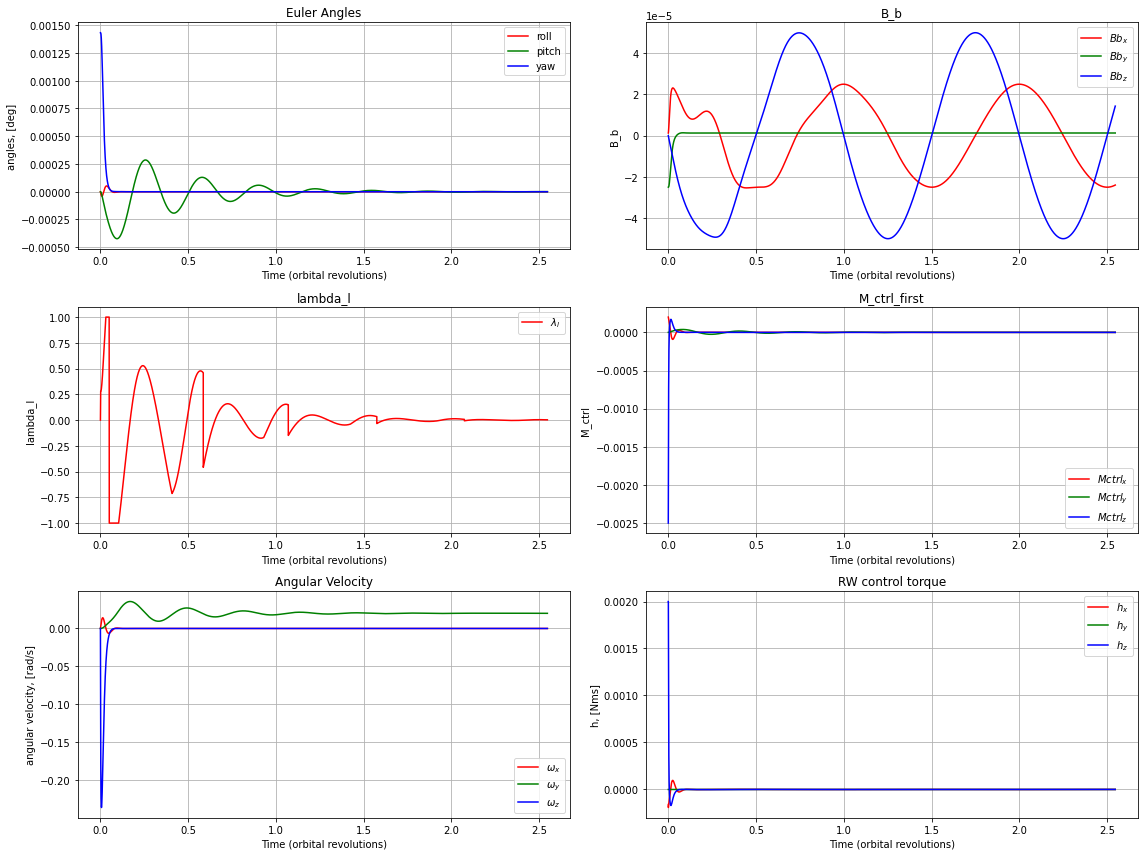

In [292]:
plotting(t, x)

## Искусственный потенциал

### Функция Ляпунова с поправкой (APF):

Новая функция Ляпунова с дополнительным потенциалом (APF):  
$$
V = \frac{1}{2} \boldsymbol{\omega}_e^T \mathbb{K}_p^{-1} \mathbf{J}^b \boldsymbol{\omega}_e +
(1 - q_{e, 0}^2) + \Lambda_v \\
\Lambda_v = \frac{1}{2} \alpha \exp \left[- \gamma \sum_i B_i^2 \right], \qquad i \in S
$$
где $B_i$ - компоненты локального магнитного поля $\mathbf{B}^b$

Производная по времени дает (при $v=3$):
$$
\dot{V} = \boldsymbol{\omega}_e^T \mathbb{K}_p^{-1} \mathbf{J}^b \dot{\boldsymbol{\omega}_e} + 
(-2q_{e,0}\dot{q_{e,0}}) - \underbrace{\alpha \gamma \exp \left[- \gamma \sum_i B_i^2 \right]}_{\psi} 
(B_x \dot{B_x} + B_y \dot{B_y})
$$

Уравнения для ошибок:
$$
\dot{q}_{e,0} = - \frac{1}{2} \boldsymbol{\omega}_e^T \boldsymbol{q}_e \\
\dot{\boldsymbol{\omega}}_e = (\mathbf{J}^b)^{-1} \lbrace -\boldsymbol{\omega}^b \times 
(\mathbf{J}^b \boldsymbol{\omega}^b + \boldsymbol{h}_w) + \mathbf{M}_{ctrl}^b + 
\mathbf{J}^b \left[ \boldsymbol{\omega}_e \times (\tilde{q}_e \circ \boldsymbol{\omega}_d \circ q_e) - 
\tilde{q}_e \circ \dot{\boldsymbol{\omega}}_d \circ q_e \right] \rbrace
$$

### Магнитное поле
Уравнения для подсчета производной магнитного поля (из дополнения C):
$$
\dot{\mathbf{B}}^b \vert_b = \dot{\mathbf{B}}^b \vert_i - \boldsymbol{\omega}^b \times \mathbf{B}^b \\
\dot{\mathbf{B}}^b \vert_i = q^{bo} \circ \dot{\mathbf{B}}^o \vert_i \circ \tilde{q}^{bo} \\
\dot{\mathbf{B}}^o \vert_i = \dot{\mathbf{B}}^o \vert_o + [0 \quad \omega_0 \quad 0]^T \times \mathbf{B}^o
$$

Как и раньше, магнитное поле Земли представляется моделью диполя с уравнением:
$$
\mathbf{B}^o = B_0
\begin{bmatrix}
\cos(u) \sin(\epsilon) \\
\cos(\epsilon) \\
-2 \sin(u) \sin(\epsilon)
\end{bmatrix}
$$

Принимая $B_0, \epsilon$ за постоянные величины и учитывая, что $\dot{u} = \omega_0$, получается:
$$
\dot{\mathbf{B}}^o \vert_o = - \omega_0 B_0 \sin(\epsilon)
\begin{bmatrix}
\sin(u) \\
0 \\
2 \cos(u)
\end{bmatrix}
$$

Подставляя в крайнее из трех уравнений выше на магнитное поле (здесь мне кажется описка в статье в векторе (С7)):
$$
\dot{\mathbf{B}}^o \vert_i = -3 \omega_0 B_0 \sin(\epsilon)
\begin{bmatrix}
\sin(u) \\
0 \\
\cos(u)
\end{bmatrix}
$$

### Закон управления
Чтобы в уравнении на производную функции Ляпунова вынести слева $\boldsymbol{\omega}_e^T$, представлю второй множитель $\psi$ как:
$$
(B_x \dot{B_x} + B_y \dot{B_y}) = \boldsymbol{\omega}_e^T \frac{\boldsymbol{\omega}_e}
{\lVert \boldsymbol{\omega}_e \rVert^2} (B_x \dot{B_x} + B_y \dot{B_y}) = 
\boldsymbol{\omega}_e^T \boldsymbol{p}
$$

В конечном итоге уравнение на производную функции Ляпунова:
$$
\dot{V} = \boldsymbol{\omega}_e^T \lbrace q_{e,0} \boldsymbol{q}_e - \psi \boldsymbol{p} +
\mathbb{K}_p^{-1} \lbrace -\boldsymbol{\omega}^b \times 
(\mathbf{J}^b \boldsymbol{\omega}^b + \boldsymbol{h}_w) + \mathbf{M}_{ctrl}^b + 
\mathbf{J}^b \left[ \boldsymbol{\omega}_e \times (\tilde{q}_e \circ \boldsymbol{\omega}_d \circ q_e) - 
\tilde{q}_e \circ \dot{\boldsymbol{\omega}}_d \circ q_e \right] \rbrace \rbrace
$$
где вектор $\boldsymbol{p}$ определяется как:
$$
\boldsymbol{p} =  \frac{\boldsymbol{\omega}_e}{\lVert \boldsymbol{\omega}_e \rVert^2} (B_x \dot{B_x} + B_y \dot{B_y})
$$

Учитывая, что $\dot{\boldsymbol{\omega}}_d = 0$, выписывается закон управления:
$$
\mathbf{M}_{ctrl}^b = \boldsymbol{\omega}^b \times (\mathbf{J}^b \boldsymbol{\omega}^b + \boldsymbol{h}_w) -
\mathbb{K}_p (q_{e,0} \boldsymbol{q}_e - \psi \boldsymbol{p}) - \mathbb{K}_d \boldsymbol{\omega}_e
$$

Комментарий по коду:  
В случае поломки z-маховика (v = 2), в статье приводится более компактная форма для вектора $\boldsymbol{p}$ (18) в приближении нахождения около цели (т.е. аппарат близко направлен на Землю):
$$
\boldsymbol{p} =
\begin{bmatrix}
B_y B_z \\
- B_x [B_z + 3 B_0 \sin(\epsilon) \sin(u)] \\
0
\end{bmatrix}
$$

In [310]:
def levi_civita(i, j, k):
    return (i-j)*(j-k)*(k-i)/2

def ctrl_torque_APF(t, quat, omega, h, ctrl, J):
    
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    dw = omega - rotate_vec_with_quat(dq, ctrl.omega_req)
    
    u_angle = ctrl.w0 * t
    B_o = B_fun(u_angle, incl, B_0)
    B_b = rotate_vec_with_quat(dq, B_o)

    # Calculation vector p according to theory above
    l_vec = np.array([np.sin(u_angle), 0, np.cos(u_angle)])
#     dBo_i = - 3 * ctrl.w0 * B_0 * np.sin(incl) * l_vec
    dBo_i = - 3 * omega[1] * B_0 * np.sin(incl) * l_vec
    dBb_i = rotate_vec_with_quat(dq, dBo_i)
#     dBb_i = rotate_vec_with_quat(quat_conjugate(dq), dBo_i)
#     dBb_i = dBo_i
    dBb_b = dBb_i - cross_product(omega, B_b)
#     dBb_b = dBb_i - cross_product(dw, B_b)
  
#     print(f"psi = {psi}")
    p = np.sum(B_b[ctrl.S] * dBb_b[ctrl.S]) * dw / np.sum(dw ** 2)
    
    
    # p for v=2 from paper (18)
#     if ctrl.v == 2:
    p = np.zeros(3)
    p[0] = B_b[1] * B_b[2]
    p[1] = - B_b[0] * (B_b[2] + 3 * B_0 * np.sin(incl) * np.sin(u_angle))
    
    
    psi = ctrl.alpha * ctrl.gamma * np.exp(-ctrl.gamma * (np.sum(B_b[ctrl.S] ** 2)))

    M_ctrl = np.zeros(3)
    M_ctrl = cross_product(omega, J @ omega + h) - ctrl.K_d @ dw - ctrl.K_p @ (dq[0] * dq[1:] - psi * p)

    v = ctrl.v
    k = ctrl.S[np.argmin(np.abs(B_b[ctrl.S]))]
    l = ctrl.S[np.argmax(np.abs(B_b[ctrl.S]))]

    lambda_l = M_ctrl[v] / B_b[l]
    if np.abs(lambda_l) > ctrl.m_max:
        lambda_l *= ctrl.m_max / np.abs(lambda_l)

    u, m = np.zeros(3), np.zeros(3)
    u[k] = M_ctrl[k]
    u[l] = M_ctrl[l] + B_b[v] * lambda_l
    m[k] = lambda_l * levi_civita(v, k, l)
    if np.max(np.abs(u)) > ctrl.dh_max:
        u *= ctrl.dh_max / np.max(np.abs(u))

    for i in range(3):
        if np.abs(h[i]) / ctrl.h_max > 0.99 and u[i] * h[i] < 0:
            u[i] = 0
    
    M_ctrl = u + cross_product(m, B_b)
    
    return u, M_ctrl, B_b, B_o, lambda_l, psi


def rhs_APF(t, x, sat, ctrl):

    print(f"t = {t}")
        
    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:]

    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    dw = omega - rotate_vec_with_quat(dq, ctrl.omega_req)

    u, M_ctrl, B_b, B_o = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)
    psi, lambda_l = np.zeros(1), np.zeros(1)
    u, M_ctrl, B_b, B_o, lambda_l, psi = ctrl_torque_APF(t, quat, omega, h, ctrl, sat.J)

    x_dot = np.zeros(10)

    x_dot[0] = -0.5 * quat[1:] @ dw
    x_dot[1:4] = 0.5 * (quat[0] * dw + cross_product(quat[1:], dw))
    x_dot[4:7] = sat.J_inv @ (M_ctrl - cross_product(omega, sat.J @ omega + h))
    x_dot[7:] = -u
    
    return x_dot

In [305]:
def plotting_APF(x, t):
    
    u = np.zeros((np.size(t), 3))
    M_ctrl_final, B_b, B_o = np.zeros((np.size(t), 3)), np.zeros((np.size(t), 3)), np.zeros((np.size(t), 3))
    lambda_l = np.zeros(np.size(t))
#     k = np.zeros(np.size(t))
#     l = np.zeros(np.size(t))
    psi, lambda_l = np.zeros(np.size(t)), np.zeros(np.size(t))
    dw, dq = np.zeros((np.size(t), 3)), np.zeros((np.size(t), 4))
#     M_ctrl_first = np.zeros((np.size(t), 3))
    for i in range(np.size(t)):
        quat = x[i,:4] / np.linalg.norm(x[i,:4])
        omega = x[i,4:7]
        h = x[i,7:]
        u[i], M_ctrl_final[i], B_b[i], B_o[i], lambda_l[i], psi[i] = ctrl_torque_APF(t[i], quat, omega, h, ctrl, sat.J)
        dq[i] = quat_product(quat_conjugate(ctrl.q_req), quat)
        dw[i] = omega - rotate_vec_with_quat(dq[i], ctrl.omega_req)
#         M_ctrl_first[i] = cross_product(omega, sat.J @ omega + h) - ctrl.K_d @ dw[i] - dq[i,0] * ctrl.K_p @ dq[i,1:]
#         k[i] = ctrl.S[np.argmin(np.abs(B_b[i, ctrl.S]))]
#         l[i] = ctrl.S[np.argmax(np.abs(B_b[i, ctrl.S]))]


    roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
    # Seconds to orbital revolutions
    t = t / (2 * np.pi / ctrl.w0)
    
    fig1 = plt.figure(figsize=(16,12))
    ax1 = fig1.add_subplot(3,2,1)

    ax1.set_title("Euler Angles")
#     ax1.plot(t, roll, label = 'roll', color = 'red')
#     ax1.plot(t, pitch, label = 'pitch', color = 'green')
#     ax1.plot(t, yaw, label = 'yaw', color = 'blue')
    ax1.plot(t, 2 * np.arccos(x[:,0]) * 180 / np.pi, label = 'deg', color = 'red')
    ax1.set_ylabel(r'angles, [deg]')
    ax1.set_xlabel(r'Time (orbital revolutions)')
    ax1.grid(True)
    ax1.legend()

    ax2 = fig1.add_subplot(3,2,2)

    ax2.set_title("B_b")
    ax2.plot(t, B_b[:, 0], label = '$Bb_x$', color = 'red')
    ax2.plot(t, B_b[:, 1], label = '$Bb_y$', color = 'green')
    ax2.plot(t, B_b[:, 2], label = '$Bb_z$', color = 'blue')
    ax2.set_ylabel(r'B_b')
    ax2.set_xlabel(r'Time (orbital revolutions)')
    ax2.grid(True)
    ax2.legend()

    ax3 = fig1.add_subplot(3,2,3)

#     ax3.set_title("RW angular momentum")
#     ax3.plot(t, x[:,7], label = '$h_x$', color = 'red')
#     ax3.plot(t, x[:,8], label = '$h_y$', color = 'green')
#     ax3.plot(t, x[:,9], label = '$h_z$', color = 'blue')
#     ax3.set_ylabel(r'h, [Nms]')
#     ax3.set_xlabel(r't, [s]')
#     ax3.grid(True)
#     ax3.legend()

#     ax3.set_title("lambda_l")
#     ax3.plot(t, lambda_l, label = '$\lambda_l$', color = 'red')
#     ax3.set_ylabel(r'lambda_l')
    ax3.set_title("psi")
    ax3.plot(t, psi, label = '$\psi$', color = 'red')
    ax3.set_ylabel(r'psi')
    ax3.set_xlabel(r'Time (orbital revolutions)')
    ax3.grid(True)
    ax3.legend()

    ax4 = fig1.add_subplot(3,2,4)

    # Actual M_ctrl
    ax4.set_title("M_ctrl_final")
#     ax4.plot(t, M_ctrl_final[:, 0] - M_ctrl_first[:, 0], label = '$Mctrl_x$', color = 'red')
#     ax4.plot(t, M_ctrl_final[:, 1] - M_ctrl_first[:, 1], label = '$Mctrl_y$', color = 'green')
#     ax4.plot(t, M_ctrl_final[:, 2] - M_ctrl_first[:, 2], label = '$Mctrl_z$', color = 'blue')
    ax4.plot(t, M_ctrl_final[:, 0], label = '$Mctrl_x$', color = 'red')
    ax4.plot(t, M_ctrl_final[:, 1], label = '$Mctrl_y$', color = 'green')
    ax4.plot(t, M_ctrl_final[:, 2], label = '$Mctrl_z$', color = 'blue')
    ax4.set_ylabel(r'M_ctrl')
    ax4.set_xlabel(r'Time (orbital revolutions)')
    ax4.grid(True)
    ax4.legend()

    # ax4.set_title("B_o - B_b")
    # ax4.plot(t, B_o[:, 0] - B_b[:, 0], label = '$Bo_x - Bb_x$', color = 'red')
    # ax4.plot(t, B_o[:, 1] - B_b[:, 1], label = '$Bo_y - Bb_y$', color = 'green')
    # ax4.plot(t, B_o[:, 2] - B_b[:, 2], label = '$Bo_z - Bb_z$', color = 'blue')
    # ax4.set_ylabel(r'B_o - B_b')
    # ax4.set_xlabel(r't, [s]')
    # ax4.grid(True)
    # ax4.legend()

    # ax4.set_title("lambda_l")
    # ax4.plot(t, lambda_l, label = '$\lambda_l$', color = 'red')
    # ax4.set_ylabel(r'lambda_l')
    # ax4.set_xlabel(r't, [s]')
    # ax4.grid(True)
    # ax4.legend()

    ax5 = fig1.add_subplot(3,2,5)

    ax5.set_title("Angular Velocity")
    ax5.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
    ax5.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
    ax5.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
    ax5.set_ylabel(r'angular velocity, [rad/s]')
    ax5.set_xlabel(r'Time (orbital revolutions)')
    ax5.grid(True)
    ax5.legend()

    ax6 = fig1.add_subplot(3,2,6)

    ax6.set_title("RW control torque")
    ax6.plot(t, -u[:,0], label = '$h_x$', color = 'red')
    ax6.plot(t, -u[:,1], label = '$h_y$', color = 'green')
    ax6.plot(t, -u[:,2], label = '$h_z$', color = 'blue')
    ax6.set_ylabel(r'h, [Nms]')
    ax6.set_xlabel(r'Time (orbital revolutions)')
    ax6.grid(True)
    ax6.legend()

    plt.tight_layout()

In [306]:
class Parameters(object):
    pass

sat = Parameters()
sat.J = np.diag(np.array([0.0309, 0.0319, 0.0051]))
sat.J_inv = np.linalg.inv(sat.J)

ctrl = Parameters()
# v - broken RW
ctrl.v = 1
indexes = np.array([0, 1, 2])
# S = {0, 1, 2} / v
ctrl.S = np.delete(indexes, np.where(indexes == ctrl.v))
# K = np.eye(3)
# K[ctrl.v, ctrl.v] = 0.05
# ctrl.K_p = 5e-3 * K

# K_p, K_d according to paper
ctrl.K_p = np.diag(np.array([0.02, 0.02, 0.001]))
# ctrl.K_d = 1e-2 * K
ctrl.K_d = 2 * np.diag(np.array([0.02, 0.02, 0.001]))
ctrl.dh_max = 2e-3
ctrl.h_max = 19e-3
ctrl.m_max = 1

# Required w0 and q
ctrl.omega_req = np.zeros(3)
ctrl.w0 = 0.02
# ctrl.w0 = 360 * np.pi / 180 / (24 * 60 * 60)
ctrl.omega_req[1] = ctrl.w0
ctrl.q_req = np.array([1., 0., 0., 0.])

# Properties of APF
ctrl.alpha = 0.02
ctrl.gamma = 1 / (2 * (1.5e-5)**2)

alpha_0 = np.pi / 4
# x_0 = np.array([np.cos(alpha_0), 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0, 0])
x_0 = np.array([np.cos(alpha_0), 0, 0, np.sin(alpha_0), 0, 0, 0, 0, 0, 0])

t0 = 0.
tf = 800.
t_eval = np.arange(t0, tf, 0.02)

sol = solve_ivp(lambda t, x: rhs_APF(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
# sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t

t = 0.0
t = 0.0001385934083453093
t = 0.0027718681669061857
t = 0.004157802250359278
t = 0.011087472667624743
t = 0.012319414075138603
t = 0.013859340834530928
t = 0.013859340834530928
t = 0.028175711637727432
t = 0.035333897039325685
t = 0.07112482404731693
t = 0.07748765551540426
t = 0.08544119485051344
t = 0.08544119485051344
t = 0.21701909564519048
t = 0.28280804604252896
t = 0.6117527980292217
t = 0.670231865049078
t = 0.7433306988238986
t = 0.7433306988238986
t = 0.9056173972907728
t = 0.9867607465242101
t = 1.3924774926913959
t = 1.4646049142322288
t = 1.5547641911582701
t = 1.5547641911582701
t = 1.750311528611748
t = 1.8480851973384869
t = 2.3369535409721816
t = 2.423863468729283
t = 2.5325008784256595
t = 2.5325008784256595
t = 2.7680594185352727
t = 2.8858386885900793
t = 3.4747350388641127
t = 3.579427723357274
t = 3.710293578973726
t = 3.710293578973726
t = 3.976449734536533
t = 4.109527812317936
t = 4.7749182012249545
t = 4.893209825919536
t = 5.041074356787762
t = 5.0410

t = 168.83909192654002
t = 169.10899191157966
t = 169.4463668928792
t = 169.4463668928792
t = 170.06203879132337
t = 170.36987474054547
t = 171.9090544866559
t = 172.18268644151996
t = 172.52472638510005
t = 172.52472638510005
t = 173.12519858969048
t = 173.4254346919857
t = 174.92661520346184
t = 175.19349173883535
t = 175.52708740805227
t = 175.52708740805227
t = 176.1278097055631
t = 176.42817085431852
t = 177.92997659809564
t = 178.1969642858782
t = 178.53069889560646
t = 178.53069889560646
t = 179.14989459123845
t = 179.45949243905446
t = 181.00748167813444
t = 181.28267976508198
t = 181.62667737376643
t = 181.62667737376643
t = 182.27346412060092
t = 182.5968574940182
t = 184.21382436110446
t = 184.50128513747535
t = 184.86061110793895
t = 184.86061110793895
t = 185.5389190156473
t = 185.8780729695015
t = 187.57384273877238
t = 187.8753129199761
t = 188.25215064648074
t = 188.25215064648074
t = 188.9663026992469
t = 189.32337872563
t = 191.10875885754544
t = 191.42615976988594
t 

t = 386.6751382679349
t = 386.9977746661666
t = 387.40107016395626
t = 387.40107016395626
t = 388.1584633701459
t = 388.5371599732407
t = 390.43064298871485
t = 390.7672621914658
t = 391.1880361949045
t = 391.1880361949045
t = 391.93170644580704
t = 392.30354157125834
t = 394.1627171985147
t = 394.4932373100269
t = 394.90638744941725
t = 394.90638744941725
t = 395.6125215344639
t = 395.9655885769872
t = 397.7309237896039
t = 398.04476116073573
t = 398.4370578746505
t = 398.4370578746505
t = 399.1307053326609
t = 399.47752906166613
t = 401.21164770669213
t = 401.51993546580786
t = 401.9052951647025
t = 401.9052951647025
t = 402.63214774390445
t = 402.9955740335055
t = 404.81270548151036
t = 405.13575107226677
t = 405.5395580607123
t = 405.5395580607123
t = 406.31802518745764
t = 406.70725875083036
t = 408.65342656769377
t = 408.99941195735835
t = 409.4318936944391
t = 409.4318936944391
t = 410.2303005004418
t = 410.62950390344315
t = 412.62552091844987
t = 412.9803683877844
t = 413.4239

t = 634.9568597283538
t = 634.9568597283538
t = 635.811282223543
t = 636.2384934711375
t = 638.3745497091104
t = 638.7542930403056
t = 639.2289722042996
t = 639.2289722042996
t = 635.5639503993298
t = 635.8674957348178
t = 637.3852224122577
t = 637.655040488247
t = 637.9923130832336
t = 637.9923130832336
t = 638.5994037542096
t = 638.9029490896976
t = 640.4206757671375
t = 640.6904938431268
t = 641.0277664381134
t = 641.0277664381134
t = 641.6401821106618
t = 641.946389946936
t = 643.4774291283071
t = 643.749613871662
t = 644.0898448008555
t = 644.0898448008555
t = 644.6902139773651
t = 644.9903985656199
t = 646.4913215068939
t = 646.7581522520093
t = 647.0916906834035
t = 647.0916906834035
t = 647.6946212623656
t = 647.9960865518467
t = 649.503412999252
t = 649.7713821454573
t = 650.106343578214
t = 650.106343578214
t = 650.7279926760312
t = 651.0388172249399
t = 652.5929399694828
t = 652.8692284574016
t = 653.2145890673
t = 653.2145890673
t = 653.8642469220426
t = 654.1890758494138
t

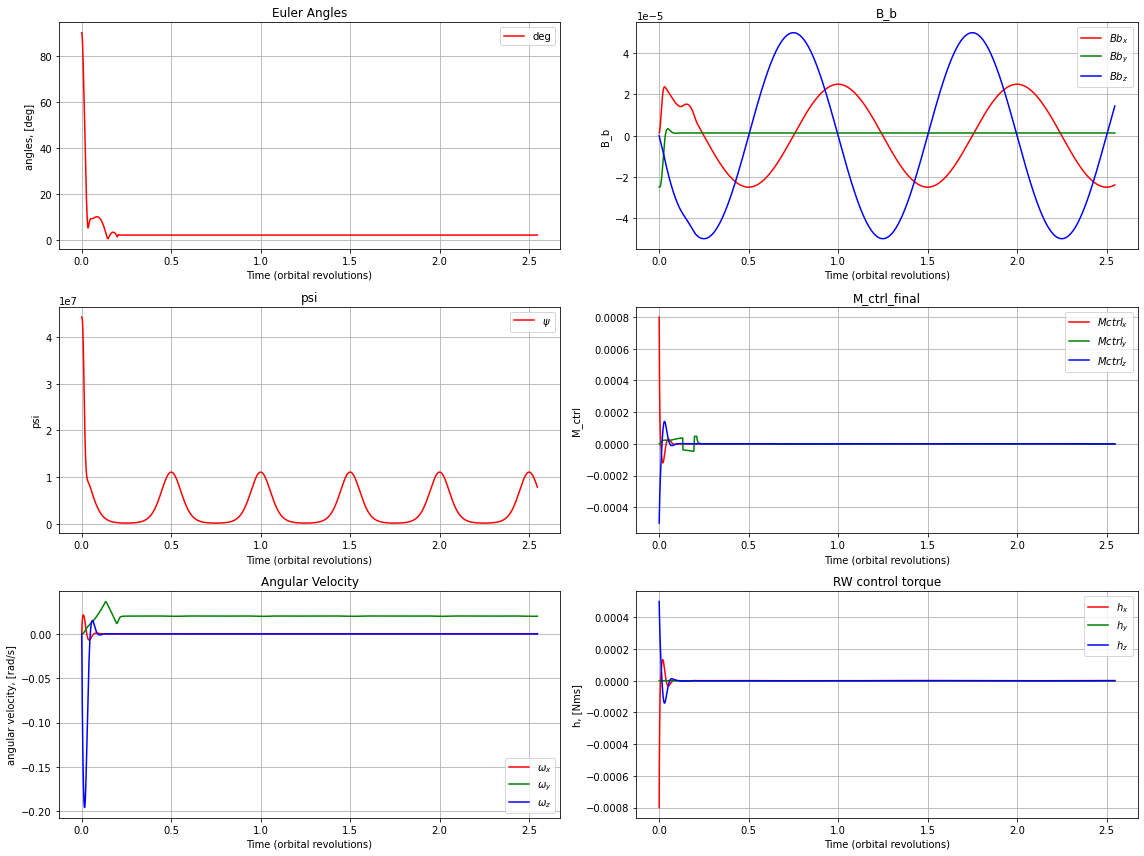

In [307]:
plotting_APF(x, t)